## 1.卷积神经网络

### 卷积

Text(0.5, 1.0, 'sharp')

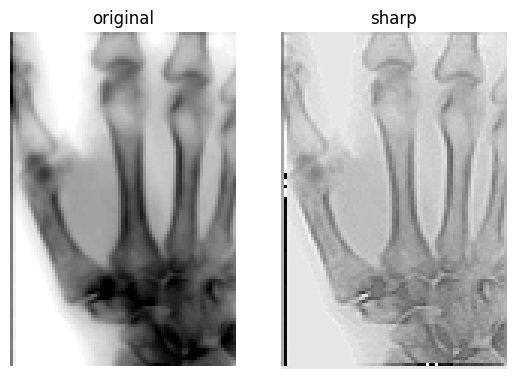

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
# %matplotlib inline

I_xray = imread('data/xray_image.png')[::4,::4]
# make sure to copy, otherwise they reference the same memory (same variable)
I_xray_sharp = I_xray.copy()

im_size = I_xray.shape

#### your code starts ####
## step 1. create the kernel matrix
# kernel = np.array([[-1, -1, -1],
#                    [-1, 7, -1],
#                    [-1, -1, -1]])
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
## step 2 & 3. modify the median filter code for filtering
# 卷积核大小
psz_h = 1

# 使用块级操作进行锐化滤波
for row in range(psz_h, im_size[0] - psz_h):
    for col in range(psz_h, im_size[1] - psz_h):
        # 提取 3x3 的图像块
        patch = I_xray[row - psz_h: row + psz_h + 1, col - psz_h: col + psz_h + 1]
        # 进行卷积操作：元素乘积并求和
        I_xray_sharp[row, col] = np.sum(patch * kernel)

# 将值限制在 0 到 255 之间，防止溢出
I_xray_sharp = np.clip(I_xray_sharp, 0, 255).astype(np.uint8)

#### your code starts ####

plt.subplot(121)
plt.imshow(I_xray, cmap='gray');plt.axis('off');plt.title('original')
plt.subplot(122)
plt.imshow(I_xray_sharp, cmap='gray');plt.axis('off');plt.title('sharp')

### 池化

In [2]:
import torch
import torch.nn.functional as F

# 构造 1x1x4x4 特征图
feature_map = torch.tensor([[[[1, 3, 2, 4],
                              [5, 6, 7, 8],
                              [2, 4, 1, 3],
                              [0, 1, 2, 4]]]], dtype=torch.float32)

print("输入特征图：")
print(feature_map[0,0])

# 1. 最大池化（2x2，stride=2）
max_pooled = F.max_pool2d(feature_map, kernel_size=2, stride=2)
print("\n最大池化结果：")
print(max_pooled[0,0])

# 2. 平均池化（2x2，stride=2）
avg_pooled = F.avg_pool2d(feature_map, kernel_size=2, stride=2)
print("\n平均池化结果：")
print(avg_pooled[0,0])

# 3. 全局最大池化（整个特征图）
global_max = F.adaptive_max_pool2d(feature_map, output_size=1)
print("\n全局最大池化结果：")
print(global_max[0,0])

# 4. 全局平均池化（整个特征图）
global_avg = F.adaptive_avg_pool2d(feature_map, output_size=1)
print("\n全局平均池化结果：")
print(global_avg[0,0])

输入特征图：
tensor([[1., 3., 2., 4.],
        [5., 6., 7., 8.],
        [2., 4., 1., 3.],
        [0., 1., 2., 4.]])

最大池化结果：
tensor([[6., 8.],
        [4., 4.]])

平均池化结果：
tensor([[3.7500, 5.2500],
        [1.7500, 2.5000]])

全局最大池化结果：
tensor([[8.]])

全局平均池化结果：
tensor([[3.3125]])


## 2.循环神经网络

### 标准RNN

In [4]:
import torch
import torch.nn as nn

# 定义一个标准 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        # RNN 层
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态 h0 (batch_size, num_layers, hidden_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # RNN 前向传播
        out, _ = self.rnn(x, h0)
        # 取最后时间步的隐藏状态作为输出
        out = self.fc(out[:, -1, :])
        return out

# 示例：输入大小=10，隐藏层=20，输出大小=2
model = RNNModel(input_size=10, hidden_size=20, output_size=2)
x = torch.randn(5, 7, 10)  # (batch=5, seq_len=7, input_size=10)
y = model(x)
print(y.shape)  # 输出: (5, 2)

torch.Size([5, 2])


### LSTM

In [5]:
import torch
import torch.nn as nn

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态 (h0, c0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))
        # 取最后时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# 示例：输入大小=10，隐藏层=20，输出大小=2
model = LSTMModel(input_size=10, hidden_size=20, output_size=2)
x = torch.randn(5, 7, 10)  # (batch=5, seq_len=7, input_size=10)
y = model(x)
print(y.shape)  # 输出: (5, 2)

torch.Size([5, 2])


### GRU

In [6]:
import torch
import torch.nn as nn

# 定义 GRU 模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # GRU 层
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态 h0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # GRU 前向传播
        out, _ = self.gru(x, h0)
        # 取最后时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# 示例：输入大小=10，隐藏层=20，输出大小=2
model = GRUModel(input_size=10, hidden_size=20, output_size=2)
x = torch.randn(5, 7, 10)  # (batch=5, seq_len=7, input_size=10)
y = model(x)
print(y.shape)  # 输出: (5, 2)

torch.Size([5, 2])


### Seq2Seq

In [7]:
import torch
import torch.nn as nn

# 编码器
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell  # 返回最后的隐藏状态和记忆单元

# 解码器
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(outputs)
        return predictions, hidden, cell

# Seq2Seq 模型
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(src)
        outputs = []
        input = trg[:, 0:1, :]  # 第一个输入 (起始符号)

        for t in range(1, trg.size(1)):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs.append(output)
            # 是否使用教师强制
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t:t+1, :] if teacher_force else output
        return torch.cat(outputs, dim=1)

# 示例
encoder = Encoder(input_size=10, hidden_size=20)
decoder = Decoder(output_size=10, hidden_size=20)
model = Seq2Seq(encoder, decoder)

src = torch.randn(5, 7, 10)  # (batch=5, seq_len=7, input_size=10)
trg = torch.randn(5, 9, 10)  # (batch=5, seq_len=9, output_size=10)
out = model(src, trg)
print(out.shape)  # 输出: (5, 8, 10)

torch.Size([5, 8, 10])


### Attention

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, hidden_size)
        # encoder_outputs: (batch, seq_len, hidden_size)
        # 计算对齐分数
        scores = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)  # (batch, seq_len)
        attn_weights = F.softmax(scores, dim=1)  # 注意力权重
        # 计算上下文向量
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (batch, 1, hidden_size)
        context = context.squeeze(1)  # (batch, hidden_size)
        return context, attn_weights

# 示例
batch_size, seq_len, hidden_size = 5, 7, 20
encoder_outputs = torch.randn(batch_size, seq_len, hidden_size)
hidden = torch.randn(batch_size, hidden_size)

attn = Attention(hidden_size)
context, weights = attn(hidden, encoder_outputs)
print(context.shape)  # (5, 20)
print(weights.shape)  # (5, 7)

torch.Size([5, 20])
torch.Size([5, 7])


## 3.Transformer与注意力机制

### Self Attention

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert embed_size % heads == 0, "Embedding size must be divisible by heads"

        self.W_Q = nn.Linear(embed_size, embed_size, bias=False)
        self.W_K = nn.Linear(embed_size, embed_size, bias=False)
        self.W_V = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        N, seq_len, embed_size = x.shape
        Q = self.W_Q(x).view(N, seq_len, self.heads, self.head_dim)
        K = self.W_K(x).view(N, seq_len, self.heads, self.head_dim)
        V = self.W_V(x).view(N, seq_len, self.heads, self.head_dim)

        Q, K, V = Q.transpose(1,2), K.transpose(1,2), V.transpose(1,2)  # (N, heads, seq_len, head_dim)

        energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (N, heads, seq_len, seq_len)
        attention = F.softmax(energy, dim=-1)

        out = torch.matmul(attention, V)  # (N, heads, seq_len, head_dim)
        out = out.transpose(1,2).contiguous().view(N, seq_len, embed_size)
        return self.fc_out(out)

# 示例
x = torch.randn(5, 7, 32)  # (batch=5, seq_len=7, embed_size=32)
self_attn = SelfAttention(embed_size=32, heads=4)
out = self_attn(x)
print(out.shape)  # (5, 7, 32)

torch.Size([5, 7, 32])


### Bert

In [1]:
import torch
import torch.nn as nn
import math

# ----------------------
# 1. Multi-Head Self Attention
# ----------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim 必须能被 num_heads 整除"
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key   = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.out   = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, mask=None):
        B, L, D = x.size()  # batch_size, seq_len, hidden_dim
        
        # 线性映射
        Q = self.query(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)  # [B, heads, L, head_dim]
        K = self.key(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, heads, L, L]
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        
        out = torch.matmul(attn, V)  # [B, heads, L, head_dim]
        out = out.transpose(1, 2).contiguous().view(B, L, D)  # [B, L, hidden_dim]
        return self.out(out)

# ----------------------
# 2. Transformer Encoder Block
# ----------------------
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, hidden_dim)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-Attention + 残差
        attn_out = self.attn(x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed Forward + 残差
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

# ----------------------
# 3. BERT Embeddings
# ----------------------
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, hidden_dim, max_len=512, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb   = nn.Embedding(max_len, hidden_dim)
        self.seg_emb   = nn.Embedding(2, hidden_dim)  # segment A / B
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids, segment_ids):
        B, L = input_ids.size()
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
        
        x = self.token_emb(input_ids) + self.pos_emb(pos_ids) + self.seg_emb(segment_ids)
        return self.dropout(self.norm(x))

# ----------------------
# 4. BERT Model
# ----------------------
class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_dim=768, num_heads=12, ff_dim=3072, num_layers=12, max_len=512):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, hidden_dim, max_len)
        self.layers = nn.ModuleList([
            TransformerBlock(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.cls_head = nn.Linear(hidden_dim, vocab_size)  # 用于 MLM
    
    def forward(self, input_ids, segment_ids, mask=None):
        x = self.embedding(input_ids, segment_ids)
        for layer in self.layers:
            x = layer(x, mask)
        logits = self.cls_head(x)  # MLM 任务输出
        return logits

In [2]:
# 模拟输入
vocab_size = 30522  # 与 BERT 一致
model = BERT(vocab_size)

input_ids = torch.randint(0, vocab_size, (2, 10))  # batch_size=2, seq_len=10
segment_ids = torch.zeros_like(input_ids)  # 全部属于句子 A

logits = model(input_ids, segment_ids)
print(logits.shape)  # [2, 10, vocab_size]

torch.Size([2, 10, 30522])


### GPT

In [3]:
import torch
import torch.nn as nn
import math

class GPTBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, hidden_dim)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_out, _ = self.attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class GPT(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, num_heads=4, ff_dim=512, num_layers=4, max_len=128):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        self.layers = nn.ModuleList([GPTBlock(hidden_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        B, L = x.size()
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        x = self.token_emb(x) + self.pos_emb(pos)
        
        # Mask：防止看到未来的 token
        mask = torch.triu(torch.ones(L, L, device=x.device), diagonal=1).bool()
        
        for layer in self.layers:
            x = layer(x, mask)
        x = self.ln_f(x)
        return self.head(x)

# 测试
vocab_size = 5000
model = GPT(vocab_size)
input_ids = torch.randint(0, vocab_size, (2, 10))
logits = model(input_ids)
print(logits.shape)  # [2, 10, vocab_size]

torch.Size([2, 10, 5000])


### Vision Transformer

In [4]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, emb_dim=768):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_ch, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size) ** 2
    
    def forward(self, x):
        x = self.patch_embed(x)  # [B, emb_dim, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, emb_dim]
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim=768, num_heads=12, ff_dim=3072, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_dim, num_heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, emb_dim)
        )
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, emb_dim=768, num_heads=12, ff_dim=3072, num_layers=12, num_classes=1000):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_ch, emb_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.zeros(1, 1 + self.patch_embedding.num_patches, emb_dim))
        
        self.layers = nn.ModuleList([TransformerEncoder(emb_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)
    
    def forward(self, x):
        B = x.size(0)
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) + self.pos_emb
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.norm(x)
        cls_out = x[:, 0]  # [CLS] Token
        return self.head(cls_out)

# 测试
model = VisionTransformer()
dummy = torch.randn(2, 3, 224, 224)
logits = model(dummy)
print(logits.shape)  # [2, 1000]

torch.Size([2, 1000])


## 4.生成与表示模型

### AE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义自编码器
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=32):
        super().__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 输出归一化到 [0,1]
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# 模拟训练
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x = torch.rand(16, 784)  # batch_size=16, MNIST 展平输入
output = model(x)
loss = criterion(output, x)
loss.backward()
optimizer.step()

print("Reconstruction Loss:", loss.item())

Reconstruction Loss: 0.0845540389418602


### VAE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        # 编码器
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # 解码器
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 测试
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
x = torch.rand(16, 784)  # batch_size=16
recon_x, mu, logvar = model(x)
loss = loss_function(recon_x, x, mu, logvar)
loss.backward()
optimizer.step()

print("VAE Loss:", loss.item())

VAE Loss: 8795.5419921875


### GAN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# 生成器
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# 判别器
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# 初始化
noise_dim = 100
G = Generator(noise_dim)
D = Discriminator()
criterion = nn.BCELoss()
optim_G = optim.Adam(G.parameters(), lr=0.0002)
optim_D = optim.Adam(D.parameters(), lr=0.0002)

# 模拟训练
real_data = torch.rand(16, 784) * 2 - 1  # [-1, 1] 区间
z = torch.randn(16, noise_dim)
fake_data = G(z)

# 判别器训练
real_labels = torch.ones(16, 1)
fake_labels = torch.zeros(16, 1)
loss_real = criterion(D(real_data), real_labels)
loss_fake = criterion(D(fake_data.detach()), fake_labels)
loss_D = loss_real + loss_fake
optim_D.zero_grad()
loss_D.backward()
optim_D.step()

# 生成器训练
loss_G = criterion(D(fake_data), real_labels)
optim_G.zero_grad()
loss_G.backward()
optim_G.step()

print("Loss_D:", loss_D.item(), "Loss_G:", loss_G.item())

Loss_D: 1.405836582183838 Loss_G: 0.6890441179275513


### Diffusion model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# 简化版 U-Net 去噪器
class SimpleDenoiser(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + 1, dim),  # 输入 + 时间步
            nn.ReLU(),
            nn.Linear(dim, 784)
        )
    def forward(self, x, t):
        t_embed = t.float().unsqueeze(1) / 1000  # 简单时间嵌入
        return self.net(torch.cat([x, t_embed], dim=1))

# 训练过程
model = SimpleDenoiser()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x0 = torch.rand(16, 784)  # MNIST 展平
t = torch.randint(1, 1000, (16,))  # 时间步
noise = torch.randn_like(x0)

alpha_bar = torch.exp(-0.001 * t.float()).unsqueeze(1)
xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise

pred_noise = model(xt, t)
loss = nn.MSELoss()(pred_noise, noise)
loss.backward()
optimizer.step()

print("Diffusion training loss:", loss.item())

Diffusion training loss: 1.0335407257080078


### DDPM

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# 简单噪声预测网络
class NoisePredictor(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + 1, dim),
            nn.ReLU(),
            nn.Linear(dim, 784)
        )
    def forward(self, x, t):
        t_embed = t.float().unsqueeze(1) / 1000
        return self.net(torch.cat([x, t_embed], dim=1))

# 初始化
model = NoisePredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 假设有 batch 数据
x0 = torch.rand(16, 784)
t = torch.randint(1, 1000, (16,))
noise = torch.randn_like(x0)

alpha_bar = torch.exp(-0.001 * t.float()).unsqueeze(1)
xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise

# 预测噪声并计算损失
pred_noise = model(xt, t)
loss = nn.MSELoss()(pred_noise, noise)
loss.backward()
optimizer.step()

print("DDPM Loss:", loss.item())

DDPM Loss: 1.0429922342300415


### Stable Diffusion

In [3]:
import torch
import torch.nn as nn

# 简化的 U-Net 去噪模块
class UNetDenoiser(nn.Module):
    def __init__(self, latent_dim=4, cond_dim=768, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    def forward(self, z, t, cond):
        t_embed = t.float().unsqueeze(1) / 1000
        x = torch.cat([z, cond, t_embed], dim=1)
        return self.fc2(torch.relu(self.fc1(x)))

# 模拟采样
z = torch.randn(1, 4)              # 潜在噪声
cond = torch.randn(1, 768)         # 文本条件嵌入
t = torch.randint(1, 1000, (1,))   # 时间步
model = UNetDenoiser()

pred_noise = model(z, t, cond)     # 预测噪声
print("Pred noise:", pred_noise)

Pred noise: tensor([[-0.2995, -0.2235, -0.1514,  0.1756]], grad_fn=<AddmmBackward0>)


## 5.图神经网络

### GCN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, X, A_hat):
        # A_hat: 归一化后的邻接矩阵 (D^-1/2 (A+I) D^-1/2)
        out = torch.mm(A_hat, X)  # 聚合邻居信息
        out = self.linear(out)    # 线性变换
        return F.relu(out)        # 非线性激活

class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, out_dim)

    def forward(self, X, A_hat):
        h = self.gcn1(X, A_hat)
        h = self.gcn2(h, A_hat)
        return h  # 输出节点表示

# 测试
N, d = 4, 5
X = torch.rand(N, d)                 # 节点特征
A = torch.tensor([[1,1,0,0],
                  [1,1,1,0],
                  [0,1,1,1],
                  [0,0,1,1]], dtype=torch.float32)  # 邻接矩阵+自环

D = torch.diag(torch.pow(A.sum(1), -0.5))
A_hat = D @ A @ D  # 归一化邻接矩阵

model = GCN(in_dim=d, hidden_dim=8, out_dim=2)
out = model(X, A_hat)
print("节点表示：", out)

节点表示： tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<ReluBackward0>)


### GAT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.a = nn.Linear(2*out_dim, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, X, adj):
        H = self.W(X)  # 节点线性变换
        N = H.size(0)

        # 注意力系数
        a_input = torch.cat([H.repeat(1, N).view(N*N, -1),
                             H.repeat(N, 1)], dim=1).view(N, N, -1)
        e = self.leakyrelu(self.a(a_input).squeeze(2))

        # 只在邻居间计算注意力
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)

        # 聚合邻居特征
        h_prime = torch.matmul(attention, H)
        return F.elu(h_prime)

# 测试
N, d = 4, 5
X = torch.rand(N, d)
adj = torch.tensor([[1,1,0,0],
                    [1,1,1,0],
                    [0,1,1,1],
                    [0,0,1,1]], dtype=torch.float32)

gat = GATLayer(in_dim=d, out_dim=2)
out = gat(X, adj)
print("节点表示：", out)

节点表示： tensor([[-0.0585, -0.1497],
        [ 0.0352, -0.2149],
        [-0.0566, -0.1379],
        [-0.0218, -0.1714]], grad_fn=<EluBackward0>)
